In [97]:
import HyperbolicDiffEq; #reload("HyperbolicDiffEq")
using OrdinaryDiffEq

using Plots; pyplot()
using LaTeXStrings

HCL=HyperbolicDiffEq
LobattoLegendre = HCL.LobattoLegendre; UniformPeriodicMesh1D = HCL.UniformPeriodicMesh1D
compute_coefficients = HCL.compute_coefficients; evaluate_coefficients = HCL.evaluate_coefficients
semidiscretise = HCL.semidiscretise; UniformPeriodicFluxDiffDisc2D = HCL.UniformPeriodicFluxDiffDisc2D
EnergyConservativeFlux = HCL.EnergyConservativeFlux; GodunovFLux = HCL.godunov
EulerVar2D = HCL.EulerVar2D; conserved_variables = HCL.conserved_variables; SuliciuFlux=HCL.SuliciuFlux
LocalLaxFriedrichsFlux = HCL.LocalLaxFriedrichsFlux; ChandrashekarFluxEC=HCL.ChandrashekarFluxEC
IsmailRoeFluxEC=HCL.IsmailRoeFluxEC; CentralFlux=HCL.CentralFlux; RanochaFluxECandKEP=HCL.RanochaFluxECandKEP

const γ = 1.4
balance_law = HCL.Euler{Float64,2}(γ)

ϱ₀(x,y)  = 1.
vx₀(x,y) = sin(x)*cos(y)
vy₀(x,y) = -cos(x)*sin(y)
p₀(x,y)  = 100/γ + (cos(2x)+cos(2y))*3/16

u₀(x,y) = conserved_variables(ϱ₀(x,y), vx₀(x,y), vy₀(x,y), p₀(x,y), balance_law)
xmin=0.; xmax=2π; ymin=0.; ymax=2π

#fvol = CentralFlux()
#fvol = EnergyConservativeFlux()
#fvol = ChandrashekarFluxEC()
#fvol = IsmailRoeFluxEC()
fvol = RanochaFluxECandKEP()

#fnum = SuliciuFlux()
fnum = LocalLaxFriedrichsFlux()

p = 1
Nx = 25
Ny = 25

meshx = UniformPeriodicMesh1D(xmin, xmax, Nx)
meshy = UniformPeriodicMesh1D(ymin, ymax, Ny)
basis = LobattoLegendre(p)

tspan = (0., 1.)
semidisc = UniformPeriodicFluxDiffDisc2D(balance_law, meshx, meshy, basis, fvol, fnum, false)
ode = semidiscretise(semidisc, u₀, tspan)

#solve(ode, SSPRK104(), dt=tspan[end]-tspan[1], save_everystep=false)
@time sol = solve(ode, SSPRK104(), dt=1/((2p+1)*max(Nx,Ny)), save_everystep=false);


  1.001772 seconds (30.57 k allocations: 1.635 MiB)



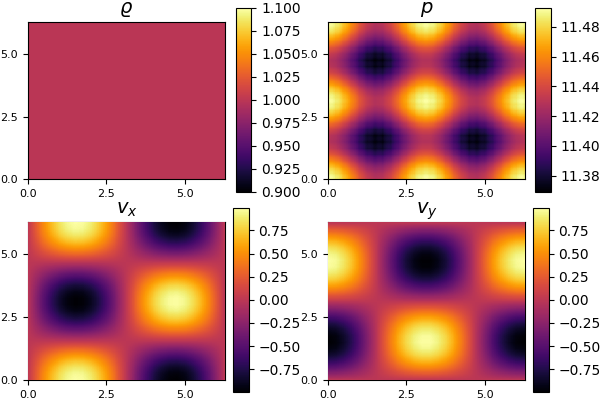


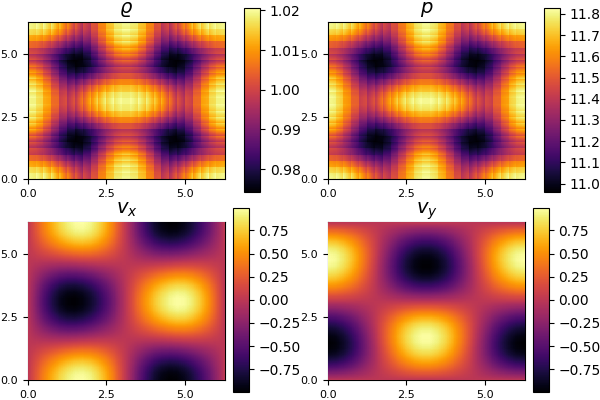

In [88]:
npoints = 10p+3


xplot, yplot, uplot = evaluate_coefficients(sol[1], meshx, meshy, basis, npoints)
heatmap((xplot, yplot, uplot, balance_law), cbar=true) |> display

xplot, yplot, uplot = evaluate_coefficients(sol[end], meshx, meshy, basis, npoints)
heatmap((xplot, yplot, uplot, balance_law), cbar=true) |> display


In [ ]:
using BenchmarkTools

fnum1 = HCL.local_lax_friedrichs
fnum2 = HCL.LocalLaxFriedrichsFlux()

uₗ = -1.; uᵣ = 3.; model = HCL.Burgers()

display(@benchmark fnum1(uₗ, uᵣ, model))
display(@benchmark fnum2(uₗ, uᵣ, model))

# Test Burgers'

In [ ]:
import HyperbolicDiffEq; reload("HyperbolicDiffEq")
using OrdinaryDiffEq

using Plots; pyplot()
using LaTeXStrings

HCL=HyperbolicDiffEq
LobattoLegendre = HCL.LobattoLegendre; UniformPeriodicMesh1D = HCL.UniformPeriodicMesh1D
compute_coefficients = HCL.compute_coefficients; evaluate_coefficients = HCL.evaluate_coefficients
semidiscretise = HCL.semidiscretise; UniformPeriodicFluxDiffDisc2D = HCL.UniformPeriodicFluxDiffDisc2D
EnergyConservativeFlux = HCL.EnergyConservativeFlux; GodunovFLux = HCL.godunov


balance_law = HCL.Burgers{Float64,2}()
u₀(x,y) = sinpi(x); xmin=0.; xmax=2.; ymin=-1.; ymax=1.

fvol = EnergyConservativeFlux()
fnum = GodunovFLux

p = 1
Nx = 50
Ny = 50

meshx = UniformPeriodicMesh1D(xmin, xmax, Nx)
meshy = UniformPeriodicMesh1D(ymin, ymax, Ny)
basis = LobattoLegendre(p)

tspan = (0., 4.)
semidisc = UniformPeriodicFluxDiffDisc2D(balance_law, meshx, meshy, basis, fvol, fnum, true)
ode = semidiscretise(semidisc, u₀, tspan)

solve(ode, SSPRK104(), dt=tspan[end]-tspan[1], save_everystep=false)
@time sol = solve(ode, SSPRK104(), dt=1./((2p+1)*max(Nx,Ny)), save_everystep=false);


In [ ]:
npoints = 10p+3

xplot, yplot, uplot = evaluate_coefficients(sol[1], meshx, meshy, basis, npoints)
heatmap(xplot, yplot, uplot) |> display

xplot, yplot, uplot = evaluate_coefficients(sol[end], meshx, meshy, basis, npoints)
heatmap(xplot, yplot, uplot) |> display

xplot, yplot, uplot = evaluate_coefficients(sol[end], meshx, meshy, basis, npoints)
plot(xplot, uplot[npoints÷2+1,:]) |> display

In [ ]:
using BenchmarkTools

reload("HyperbolicDiffEq")

u = copy(ode.u0)
du = zeros(u)
jacx = 2 / semidisc.meshx.Δx
jacy = 2 / semidisc.meshy.Δx
direction = Val{:x}()

#usethreads = Val{true}()
#usethreads = Val{false}()

#@benchmark HCL.add_flux_differences!(du, u, semidisc)
@benchmark HCL.add_numerical_fluxes!(du, u, semidisc)

#@benchmark fvol(1., 6., balance_law, direction)
#@code_native fvol(1., 6., balance_law, direction)
#@benchmark fnum(1., 6., balance_law, direction)
#@code_native fnum(1., 6., balance_law, direction)

#@code_warntype HCL.add_flux_differences!(du, u, semidisc, Val{true}())
#@code_warntype HCL.add_flux_differences_inner_loop!(du, u, balance_law, fvol, Nx, Ny, p+1, basis.D, jacx, jacy, Val{false}())

# Test Plotting

In [ ]:
import HyperbolicDiffEq; reload("HyperbolicDiffEq")

using Plots; pyplot()
using LaTeXStrings

HCL=HyperbolicDiffEq
LobattoLegendre = HCL.LobattoLegendre; UniformPeriodicMesh1D = HCL.UniformPeriodicMesh1D
compute_coefficients = HCL.compute_coefficients; evaluate_coefficients = HCL.evaluate_coefficients

u₀(x,y) = sinpi(x)*sinpi(y); xmin=-1.; xmax=1.; ymin=-1.; ymax=1.
#u₀(x,y) = (3x + y ^ 2) * abs(sin(x) + cos(y)); xmin=0.; xmax=20.; ymin=-0.; ymax=10.


p = 9
Nx = 10
Ny = 10

meshx = UniformPeriodicMesh1D(xmin, xmax, Nx)
meshy = UniformPeriodicMesh1D(ymin, ymax, Ny)
basis = LobattoLegendre(p)

u0 = compute_coefficients(u₀, meshx, meshy, basis)
xplot, yplot, uplot = evaluate_coefficients(u0, meshx, meshy, basis)


#fig = plot(xguide=L"x", yguide=L"y")
display("contour")
contour(xplot, yplot, uplot) |> display
display("contour(..., fill=true)")
contour(xplot, yplot, uplot, fill=true) |> display
display("heatmap")
heatmap(xplot, yplot, uplot) |> display
display("surface")
surface(xplot, yplot, uplot) |> display
display("contour3d")
contour3d(xplot, yplot, uplot) |> display
display("wireframe")
wireframe(xplot, yplot, uplot) |> display
display("wireframe(..., contours=true)")
wireframe(xplot, yplot, uplot, contours=true) |> display
